# Example Take-Home Challenge: Relax Inc

### Objective: Identify which factors predict future user adoption

### By Logan Larson

In [305]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
sns.set(style='dark')
import matplotlib.pyplot as plt

## load and explore data

In [306]:
# load first dataset
users = pd.read_csv('takehome_users.csv', encoding='cp437', index_col='object_id')
users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [307]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(3), object(4)
memory usage: 937.5+ KB


In [308]:
# load second dataset
eng = pd.read_csv('takehome_user_engagement.csv')
eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [309]:
eng.user_id.unique()

array([    1,     2,     3, ..., 11998, 11999, 12000])

In [310]:
eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [311]:
## clean data

# first, we have null values to take care of in the users df
# fill null 'invited_by_user_id' values with zeros
users['invited_by_user_id'].fillna(0, inplace=True)
# fill null 'last_session_creation_time' values with the first creation time
users['last_session_creation_time'].fillna(users.creation_time, inplace=True)

# convert necessary columns into datetime objects and separate into year/month/day
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['creation_year'] = users.creation_time.dt.year
users['creation_month'] = users.creation_time.dt.month
users['creation_day'] = users.creation_time.dt.day
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'])
users['last_session_year'] = users.last_session_creation_time.dt.year
users['last_session_month'] = users.last_session_creation_time.dt.month
users['last_session_day'] = users.last_session_creation_time.dt.day

eng['time_stamp'] = pd.to_datetime(eng['time_stamp'])

# get rid of unnecessary columns
users.drop(['creation_time', 'last_session_creation_time', 'name'], axis=1, inplace=True)

# make organization value categorical
users['org_id'] = users['org_id'].astype('category')

# cut emails to host name, which could be a interesting variable
users['email'] = users['email'].str.split('@').str[1]

users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 12 columns):
email                         12000 non-null object
creation_source               12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null category
invited_by_user_id            12000 non-null float64
creation_year                 12000 non-null int64
creation_month                12000 non-null int64
creation_day                  12000 non-null int64
last_session_year             12000 non-null int64
last_session_month            12000 non-null int64
last_session_day              12000 non-null int64
dtypes: category(1), float64(1), int64(8), object(2)
memory usage: 1.1+ MB


In [312]:
users.head()

,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_year,creation_month,creation_day,last_session_year,last_session_month,last_session_day
object_id,,,,,,,,,,,,
1,yahoo.com,GUEST_INVITE,1,0,11,10803.0,2014,4,22,1970,1,1
2,gustr.com,ORG_INVITE,0,0,1,316.0,2013,11,15,1970,1,1
3,gustr.com,ORG_INVITE,0,0,94,1525.0,2013,3,19,1970,1,1
4,yahoo.com,GUEST_INVITE,0,0,1,5151.0,2013,5,21,1970,1,1
5,yahoo.com,GUEST_INVITE,0,0,193,5240.0,2013,1,17,1970,1,1


In [313]:
# count user logins and identify those with at least 3 total
potential_adopters = eng.groupby('user_id').sum()
potential_adopters = potential_adopters[potential_adopters['visited'] >= 3]
potential_adopters = potential_adopters.index
potential_adopters[:10]

Int64Index([2, 10, 20, 33, 42, 43, 50, 53, 59, 60], dtype='int64', name='user_id')

In [314]:
# Find all users over 3 visited logins
active_users = eng.groupby('user_id').sum()
active_users = active_users[active_users['visited'] >= 3]
active_users_list = active_users.index
active_users_list[:10]

Int64Index([2, 10, 20, 33, 42, 43, 50, 53, 59, 60], dtype='int64', name='user_id')

In [315]:
# identify which of these users logged in three times within 7 days
adopted = []
for user in potential_adopters:
    start = 0
    count = 0
    diff = 0
    match = eng['time_stamp'][eng['user_id'] == user]
    
    for m in match:
        if start == 0:
            start = m
            diff = start + timedelta(days=7)
            count = 1
        elif m <= diff:
            count += 1
        else:
            start = 0

        if count == 3:
            adopted.append(user)
            break
            
# add column to identify users that can be considered as adopted          
users['adopted'] = 0
for user_id in users.index:
    if user_id in adopted:
        users.loc[user_id, 'adopted'] = 1
        
print('There are', sum(users['adopted']), 'users who can be considered as adopted.')

There are 1545 users who can be considered as adopted.


In [316]:
users.head()

,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_year,creation_month,creation_day,last_session_year,last_session_month,last_session_day,adopted
object_id,,,,,,,,,,,,,
1,yahoo.com,GUEST_INVITE,1,0,11,10803.0,2014,4,22,1970,1,1,0
2,gustr.com,ORG_INVITE,0,0,1,316.0,2013,11,15,1970,1,1,1
3,gustr.com,ORG_INVITE,0,0,94,1525.0,2013,3,19,1970,1,1,0
4,yahoo.com,GUEST_INVITE,0,0,1,5151.0,2013,5,21,1970,1,1,0
5,yahoo.com,GUEST_INVITE,0,0,193,5240.0,2013,1,17,1970,1,1,0


Text(0, 0.5, '')

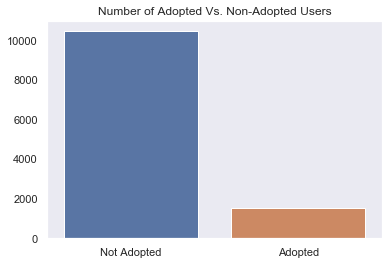

In [317]:
sns.countplot(x='adopted', data=users)
labels = ('Not Adopted', 'Adopted')
positions = (0,1)
plt.title('Number of Adopted Vs. Non-Adopted Users')
plt.xticks(positions, labels)
plt.xlabel(None)
plt.ylabel(None)

## identifying which variables predict future user adoption

In [318]:
# create dummy variables
users = pd.get_dummies(users, columns=['email', 'creation_source', drop_first=True)

# define target variable
target = 'adopted'

# define inputs and targets
X = users.drop(target, axis=1).values
y = users[target].values

# create list of feature names 
features = users.drop(target, axis=1).columns.values

In [319]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

In [320]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [321]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

LR = LogisticRegression().fit(X_train, y_train)
LR_train_pred = LR.predict(X_train)
LR_test_pred = LR.predict(X_test)

print('\n Logistic Regression baseline classifier: \n \n')
print('\n Training Classification Report: \n \n', classification_report(y_train, LR_train_pred, digits = 3, labels=[0,1]))
print('\n Test Classification Report: \n \n', classification_report(y_test, LR_test_pred, digits = 3, labels=[0,1]))

//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



 Logistic Regression baseline classifier: 
 


 Training Classification Report: 
 
               precision    recall  f1-score   support

           0      0.891     0.993     0.939      7853
           1      0.772     0.171     0.280      1147

    accuracy                          0.888      9000
   macro avg      0.831     0.582     0.610      9000
weighted avg      0.876     0.888     0.855      9000


 Test Classification Report: 
 
               precision    recall  f1-score   support

           0      0.871     0.985     0.925      2602
           1      0.333     0.048     0.084       398

    accuracy                          0.861      3000
   macro avg      0.602     0.517     0.504      3000
weighted avg      0.800     0.861     0.813      3000



In [322]:
# there is significant overfitting present, so we should proceed with tuning the hyperparameter
param_grid = {'C':np.arange(0.1,1,10)}
grid = GridSearchCV(LR, param_grid, cv=5)
grid.fit(X_train, np.ravel(y_train))
print('Optimal value of C:', grid.best_estimator_.C)

//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

Optimal value of C: 0.1


In [323]:
LR_tuned= LogisticRegression(C=grid.best_estimator_.C).fit(X_train, y_train)
LR_tuned_train_pred = LR_tuned.predict(X_train)
LR_tuned_test_pred = LR_tuned.predict(X_test)

print('\n Tuned Logistic Regression classifier: \n \n')
print('\n Training Classification Report: \n \n', classification_report(y_train, LR_tuned_train_pred, digits = 3, labels=[0,1]))
print('\n Test Classification Report: \n \n', classification_report(y_test, LR_tuned_test_pred, digits = 3, labels=[0,1]))

//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



 Tuned Logistic Regression classifier: 
 


 Training Classification Report: 
 
               precision    recall  f1-score   support

           0      0.890     0.994     0.939      7853
           1      0.793     0.160     0.267      1147

    accuracy                          0.888      9000
   macro avg      0.842     0.577     0.603      9000
weighted avg      0.878     0.888     0.853      9000


 Test Classification Report: 
 
               precision    recall  f1-score   support

           0      0.871     0.987     0.925      2602
           1      0.352     0.048     0.084       398

    accuracy                          0.862      3000
   macro avg      0.612     0.517     0.505      3000
weighted avg      0.802     0.862     0.814      3000



In [334]:
df = users.drop('adopted', axis=1)
df_coef = pd.DataFrame(zip(list(df.columns), LR_tuned.coef_[0]),index=range(df.columns.shape[0]), columns=['feature','coefficient'])
df_coef.sort_values(by='coefficient', ascending=False)[:10]

,feature,coefficient
347,email_hotmail.com,0.159380
1356,org_id_161,0.123375
1202,org_id_7,0.116955
1501,org_id_306,0.115345
1251,org_id_56,0.114895
1413,org_id_218,0.109105
1229,org_id_34,0.108209
1219,org_id_24,0.107415
1277,org_id_82,0.107104
583,email_mxecy.com,0.106352


#### Logistic regression with L1 penalty

In [324]:
# lasso

lasso = LogisticRegression(C=grid.best_estimator_.C, penalty='l1').fit(X_train,y_train)

lasso_train_pred = lasso.predict(X_train)
lasso_test_pred = lasso.predict(X_test)

print('\n Logistic Regression classifier with L1 penalty: \n \n')
print('\n Training Classification Report: \n \n', classification_report(y_train, lasso_train_pred, digits = 3, labels=[0,1]))
print('\n Test Classification Report: \n\n', classification_report(y_test, lasso_test_pred, digits = 3, labels=[0,1]))

//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



 Logistic Regression classifier with L1 penalty: 
 


 Training Classification Report: 
 
               precision    recall  f1-score   support

           0      0.888     0.997     0.939      7853
           1      0.861     0.140     0.241      1147

    accuracy                          0.888      9000
   macro avg      0.875     0.569     0.590      9000
weighted avg      0.885     0.888     0.850      9000


 Test Classification Report: 

               precision    recall  f1-score   support

           0      0.870     0.993     0.927      2602
           1      0.406     0.033     0.060       398

    accuracy                          0.865      3000
   macro avg      0.638     0.513     0.494      3000
weighted avg      0.809     0.865     0.812      3000



In [333]:
df = users.drop('adopted', axis=1)
df_coef = pd.DataFrame(zip(list(df.columns), lasso.coef_[0]),index=range(df.columns.shape[0]), columns=['feature','coefficient'])
df_coef.sort_values(by='coefficient', ascending=False)[:10]

,feature,coefficient
301,email_gmail.com,0.417362
347,email_hotmail.com,0.374700
448,email_jourrapide.com,0.292916
1120,email_yahoo.com,0.240547
138,email_cuvox.de,0.211201
314,email_gustr.com,0.209650
1356,org_id_161,0.088352
1413,org_id_218,0.074008
1501,org_id_306,0.073808
1468,org_id_273,0.069978


#### Logistic Regression with L2 Penalty

In [325]:
# ridge

ridge = LogisticRegression(C=grid.best_estimator_.C, penalty='l2').fit(X_train,y_train)

ridge_train_pred = ridge.predict(X_train)
ridge_test_pred = ridge.predict(X_test)

print('\n Logistic Regression classifier with L2 penalty: \n \n')
print('\n Training Classification Report: \n\ \n', classification_report(y_train, ridge_train_pred, digits = 3, labels=[0,1]))
print('\n Test Classification Report: \n \n', classification_report(y_test, ridge_test_pred, digits = 3, labels=[0,1]))

//miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



 Logistic Regression classifier with L2 penalty: 
 


 Training Classification Report: 
\ 
               precision    recall  f1-score   support

           0      0.890     0.994     0.939      7853
           1      0.793     0.160     0.267      1147

    accuracy                          0.888      9000
   macro avg      0.842     0.577     0.603      9000
weighted avg      0.878     0.888     0.853      9000


 Test Classification Report: 
 
               precision    recall  f1-score   support

           0      0.871     0.987     0.925      2602
           1      0.352     0.048     0.084       398

    accuracy                          0.862      3000
   macro avg      0.612     0.517     0.505      3000
weighted avg      0.802     0.862     0.814      3000



In [332]:
df = users.drop('adopted', axis=1)
df_coef = pd.DataFrame(zip(list(df.columns), ridge.coef_[0]),index=range(df.columns.shape[0]), columns=['feature','coefficient'])
df_coef.sort_values(by='coefficient', ascending=False)[:10]

,feature,coefficient
347,email_hotmail.com,0.159380
1356,org_id_161,0.123375
1202,org_id_7,0.116955
1501,org_id_306,0.115345
1251,org_id_56,0.114895
1413,org_id_218,0.109105
1229,org_id_34,0.108209
1219,org_id_24,0.107415
1277,org_id_82,0.107104
583,email_mxecy.com,0.106352


## Feature extraction with PCA

In [342]:
# Given the poor performance of the LR models, the results aren't trustworthy.
# So we'll go a different route. Instead of building a classifier, we'll
# experiment with a feature extraction technique called Principal Component Analysis
# This will convert our df into a set of linearly uncorrelated variables
# so we can get a better feel for the most influential features

from sklearn.decomposition import PCA

pca = PCA()
features = scaler.fit_transform(df)
components = pca.fit(features)
np.sum(pca.explained_variance_ratio_[0:7])

0.008886955557053402

In [339]:
df_comp = pd.DataFrame(pca.components_, columns=df.columns)
#absolute values of correlation with principal components
best_features = np.absolute(df_comp[np.absolute(df_comp) > 0.1])
best_features.head(12)

,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,creation_year,creation_month,creation_day,last_session_year,last_session_month,last_session_day,email_adpql.com,...,org_id_407,org_id_408,org_id_409,org_id_410,org_id_411,org_id_412,org_id_413,org_id_414,org_id_415,org_id_416
0,NaN,NaN,NaN,NaN,0.111332,NaN,0.501975,0.479396,0.475628,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.530359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0.564782,0.579087,NaN,0.113523,0.115676,0.113222,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.118188,0.109866,0.145927,NaN,NaN,NaN,NaN,NaN,0.104768,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.554871,0.555933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,0.321003,NaN,NaN,0.111721,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [341]:
#sum correlations to get a relative estimate of the feature importance
best_features.head(7).sum(axis=0).sort_values(ascending=False)[:10]

email_gmail.com                       0.929747
creation_source_SIGNUP_GOOGLE_AUTH    0.920902
org_id_136                            0.915848
org_id_361                            0.910196
creation_source_SIGNUP                0.786140
last_session_day                      0.693618
creation_month                        0.690419
creation_source_PERSONAL_PROJECTS     0.680120
invited_by_user_id                    0.676286
opted_in_to_mailing_list              0.673059
dtype: float64

In [364]:
users = pd.read_csv('takehome_users.csv', encoding='cp437', index_col='object_id')
users.creation_source.unique()

array(['GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'PERSONAL_PROJECTS',
       'SIGNUP_GOOGLE_AUTH'], dtype=object)

In [365]:
# cut emails to host name, which could be a interesting variable
users['email'] = users['email'].str.split('@').str[1]
x = users.email.unique()
ten = x[:10]
print('There are', len(x), 'unique email hosts in the database, including:', ten)

There are 1184 unique email hosts in the database, including: ['yahoo.com' 'gustr.com' 'jourrapide.com' 'hotmail.com' 'cuvox.de'
 'gmail.com' 'uhzdq.com' 'yyyxt.com' 'cslyn.com' 'xhtxh.com']


In [368]:
o = len(users.org_id.unique())
print('There are a total of', o, 'unique organizations in the database.')

There are a total of 417 unique organizations in the database.


## Conclusion

The classification reports of each Logisitic Regression model seemed significantly overfit. I'm thus much more inclined to favor the results from the PCA, which indicates that the factor most important to future user adoption is whether the user is primarily a Gmail user - since those with Gmail accounts likely signed up through Google authorization. Plus, it's impossible to use Google authorization without a Gmail account.

## Recommendation for Client

Based on the results of the PCA, I would urge Relax Inc. to look into what makes Google users different from users of every other email client. However, we need to keep in mind that Relax doesn't offer any quick-sign-in authorizers other than Google, such as hotmail.com or yahoo.com. It's thus possible that the lurking variable we may not be accounting for is the convenience that Google authorization provides. After all, using Google authorization means you don't have to manually input usernames, passwords, etc., plus you wouldn't even have to remember the password!
Similarly, I'd also suggest the company looks into the Org 136 and Org 361. It seems likely that there's something fundamentally different about the members of these groups compared to members of the 415 other organizations.